# INTRODUCTION

We have data from patients operated on from 1990-2020 for neck of femur (NOF) fractures.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from plotnine import *
import statsmodels.api as sm
from statsmodels.formula.api import ols

np.random.seed(123) #ensure reproducibility

#ignore errors about using jupyter notebook or sample size being too small
import warnings
warnings.simplefilter("ignore", UserWarning) 

In [2]:
mpl.rcParams.update({'errorbar.capsize': 5})

# styles from: https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')
# plt.style.use('ggplot')
# plt.style.use('fivethirtyeight')
# plt.style.use('default')

sns.set_style("whitegrid")
sns.set(font_scale=1.4)

In [170]:
df = pd.read_csv('data/nof_data.csv')

In [171]:
print(df['sex'].count(), 'NOF patients gathered')
print(df['sex'].dropna().count(), 'with no missing records')

10992 NOF patients gathered
10992 with no missing records


In [172]:
df = df.dropna()

In [173]:
df.head()

,case_num,ao_class,age,op_date,sex
0,601,13,61,22-May-89,F
1,602,17,94,21-May-89,F
2,603,24,95,21-May-89,F
3,604,22,93,23-May-89,M
4,605,18,89,23-May-89,F


In [174]:
df['op_date'] = pd.to_datetime(df['op_date'], format='%d-%b-%y')

In [175]:
df['sex'] = df['sex'].replace(['M','F'], ['Male', 'Female'])
df= df.drop(['case_num'], axis=1)

In [176]:
df.describe()

,ao_class,age
count,10992.000000,10992.000000
mean,19.974527,80.460062
std,5.033659,11.182339
min,11.000000,16.000000
25%,17.000000,76.000000
50%,19.000000,83.000000
75%,25.000000,88.000000
max,37.000000,106.000000


It's a clean and easy to understand set of data. However, the meaning of some of the column headers are not obvious:

- **case_num** = case ID
- **ao_class** = custom classification for the NOF
- **age**
- **op_date** = date of operation
- **sex**
  - 0 = male
  - 1 = female

In [177]:
import json
data = json.load(open('data/ao_classification.json', 'r'))
print('AO Classification')
for k,v in data.items():
    print(f'{k}: {v}')

AO Classification
11: Equal 175 valgus + undisplaced
12: less than 175 + undisplaced
13: Garden 2
15: Cervical + displaced
16: Cervical + vertical + displaced
17: Varus 90-150
18: Mild Garden 4
19: Varus less than 90 or severe Garden 4
20: 
21: 2 part above LT
22: 2 part into LT
23: 2 part below LT
24: Jensen 4
25: Jensen 5
26: Jensen 5  + below LT
27: 2 Part reversed
28: 2 part transverse
29: 3+ part reversed
30: 
31: 2 part spiral
32: 2 part oblique
33: 2 part transverse
34: Wedge spiral
35: Wedge Oblique
36: Wedge transverse
37: Complex


In [178]:
df.groupby('sex').describe()

ao_class                                                        age  \
          count       mean       std   min   25%   50%   75%   max   count   
sex                                                                          
Female   8160.0  19.968505  5.023427  11.0  17.0  19.0  25.0  37.0  8160.0   
Male     2832.0  19.991879  5.063874  11.0  17.0  18.0  24.0  37.0  2832.0   

                                                             
             mean        std   min   25%   50%   75%    max  
sex                                                          
Female  81.563113   9.985990  21.0  77.0  83.0  88.0  106.0  
Male    77.281780  13.581721  16.0  72.0  81.0  87.0  102.0

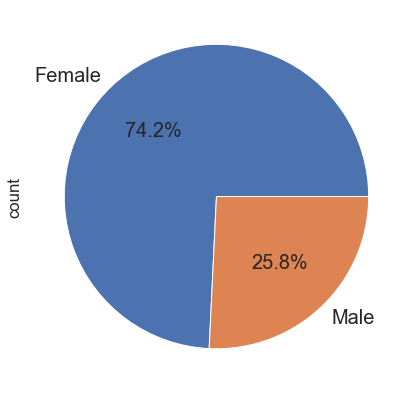

In [179]:
fig = df.groupby('sex')['age'].describe()['count'].plot(kind='pie', 
                                                            figsize=(7,7), 
                                                            autopct='%1.1f%%', 
                                                            textprops={'fontsize': 20})
plt.show()

## 74.2% female vs 25.8% male

In [180]:
df.groupby('ao_class').describe()

age                                                       
           count       mean        std   min    25%   50%    75%    max
ao_class                                                               
11         668.0  78.604790  10.700759  27.0  73.75  80.0  86.00  101.0
12         535.0  77.949533  11.692825  27.0  72.00  80.0  86.00  102.0
13         149.0  75.348993  16.044670  16.0  70.00  80.0  86.00   99.0
15          48.0  78.708333  12.714472  43.0  73.50  81.0  87.00  102.0
16          75.0  77.693333  14.262001  26.0  74.00  82.0  87.00   96.0
17        2362.0  80.113040  10.819626  22.0  75.00  82.0  87.00  106.0
18        1258.0  79.919714  10.648387  25.0  75.00  82.0  87.00  101.0
19        1259.0  81.771247   9.465447  21.0  77.00  83.0  88.00  104.0
21         470.0  80.712766  11.517505  26.0  77.00  83.0  88.00  102.0
22         690.0  79.233333  12.222385  19.0  74.00  82.0  87.00  103.0
23          42.0  81.952381  10.781539  45.0  77.25  83.5  87.75   99.0
24         651.0  82.192012  10.421944  25.0  78.00  84.0  89.00  105.0
25        2103.0  82.800761   9.938620  26.0  78.00  84.0  89.00  104.0
26          41.0  82.097561  11.676483  34.0  78.00  85.0  90.00  100.0
27          73.0  82.520548   8.930456  48.0  79.00  84.0  89.00   96.0
28          44.0  78.340909  13.273410  26.0  74.50  81.0  86.00   96.0
29         197.0  79.598985  12.603717  21.0  74.00  83.0  88.00   99.0
31          25.0  79.640000  15.529220  39.0  76.00  85.0  90.00   99.0
32          98.0  76.969388  16.894734  27.0  69.25  82.0  88.00  100.0
33          48.0  71.333333  17.255691  28.0  61.75  78.0  85.00   95.0
34          26.0  80.076923  11.845415  50.0  77.00  84.0  89.50   94.0
35          83.0  74.759036  16.707374  16.0  72.00  80.0  85.00   97.0
36           4.0  63.750000  20.155644  39.0  55.50  64.0  72.25   88.0
37          43.0  68.720930  19.530593  20.0  63.50  75.0  82.00   97.0

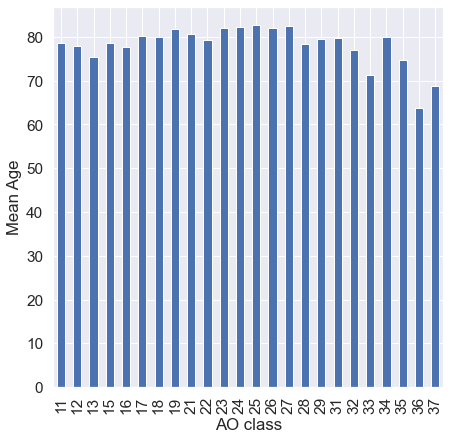

In [181]:
fig = df.groupby('ao_class')['age'].describe()['mean'].plot(kind='bar', 
                                                            figsize=(7,7))
fig.set_ylabel("Mean Age")
fig.set_xlabel("AO class")
plt.show()

## Generally the same age throughtout the AO classes

In [182]:
dfc = df.copy()

dfc['ao_class'] = dfc['ao_class'].replace([11,12,13], value='undisplaced IC')
dfc['ao_class'] = dfc['ao_class'].replace([15,16,17,16,18,19], value='displaced IC')
dfc['ao_class'] = dfc['ao_class'].replace([21,22,23], value='stable EC')
dfc['ao_class'] = dfc['ao_class'].replace([24,25,26], value='unstable EC')
dfc['ao_class'] = dfc['ao_class'].replace([27,28,29], value='transtrochanteric')
dfc['ao_class'] = dfc['ao_class'].replace([31,32,33,34,35,36,37], value='subtrochanteric')

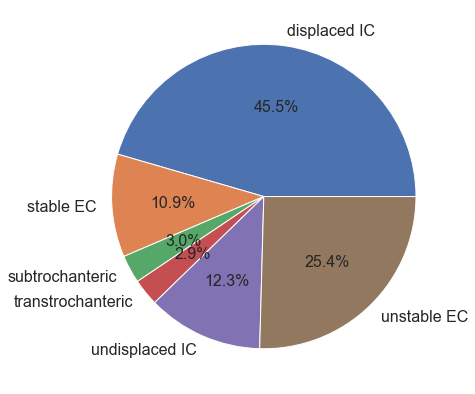

In [183]:
fig = dfc.groupby('ao_class').describe()['age']['count'].plot(kind='pie', 
                                                            figsize=(7,7), 
                                                            autopct='%1.1f%%', 
                                                            textprops={'fontsize': 16})
plt.axis('off')
plt.show()

In [184]:
dfc.groupby('ao_class').describe()['age']

,count,mean,std,min,25%,50%,75%,max
ao_class,,,,,,,,
displaced IC,5002.0,80.432027,10.561248,21.0,76.00,82.0,88.0,106.0
stable EC,1202.0,79.906822,11.921949,19.0,76.00,82.0,88.0,103.0
subtrochanteric,327.0,74.785933,17.118409,16.0,67.50,80.0,86.0,100.0
transtrochanteric,314.0,80.101911,11.999300,21.0,75.25,83.0,88.0,99.0
undisplaced IC,1352.0,77.986686,11.820824,16.0,73.00,80.0,86.0,102.0
unstable EC,2795.0,82.648658,10.079835,25.0,78.00,84.0,89.0,105.0


In [185]:
agebins = [-np.inf, 50, 60, 70, 80, np.inf]
dfc['agebins'] = pd.cut(dfc['age'], agebins, labels=['<50','50-59','60-69','70-79', '+80'])
dfc.head()

,ao_class,age,op_date,sex,agebins
0,undisplaced IC,61,1989-05-22,Female,60-69
1,displaced IC,94,1989-05-21,Female,+80
2,unstable EC,95,1989-05-21,Female,+80
3,stable EC,93,1989-05-23,Male,+80
4,displaced IC,89,1989-05-23,Female,+80


In [186]:
dfc.groupby('agebins').describe()

age                                                    
          count       mean       std   min   25%   50%   75%    max
agebins                                                            
<50       236.0  39.555085  8.829420  16.0  33.0  42.0  47.0   50.0
50-59     388.0  56.213918  2.815261  51.0  54.0  56.0  59.0   60.0
60-69    1008.0  66.314484  2.883936  61.0  64.0  67.0  69.0   70.0
70-79    2881.0  76.309268  2.771973  71.0  74.0  77.0  79.0   80.0
+80      6479.0  87.448526  4.509579  81.0  84.0  87.0  90.0  106.0

In [187]:
dfc.head()

,ao_class,age,op_date,sex,agebins
0,undisplaced IC,61,1989-05-22,Female,60-69
1,displaced IC,94,1989-05-21,Female,+80
2,unstable EC,95,1989-05-21,Female,+80
3,stable EC,93,1989-05-23,Male,+80
4,displaced IC,89,1989-05-23,Female,+80


In [188]:
dfc['rows'] = dfc['ao_class'].isin(['undisplaced IC', 'displaced IC', 'unstable EC'])

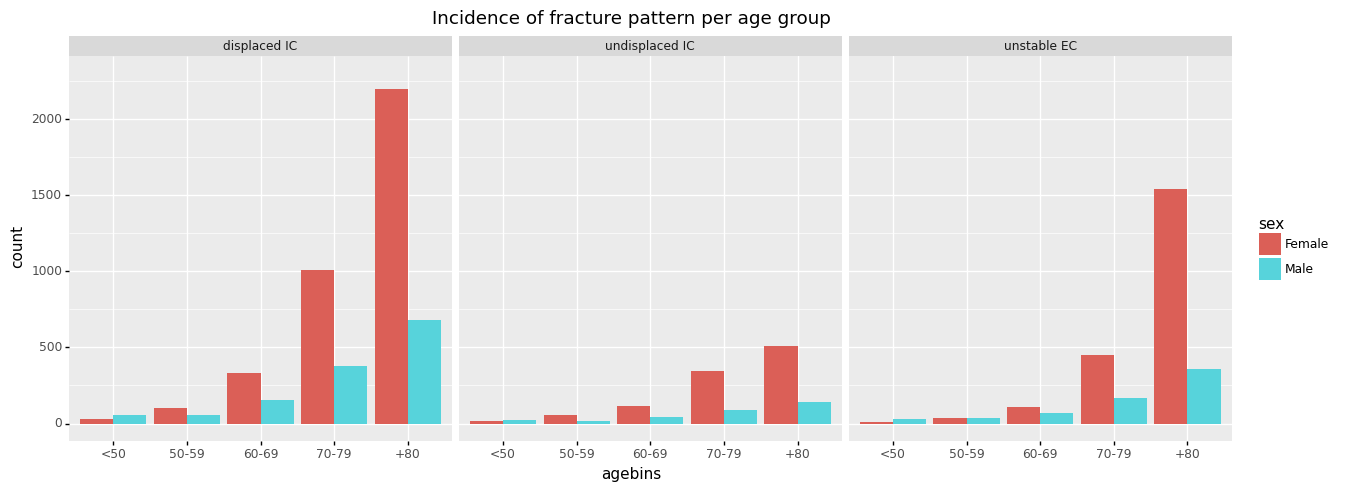

In [203]:
fig = (ggplot(dfc[dfc['rows']], aes(x='agebins', fill='sex'))
       + geom_bar(position='dodge')
       + facet_grid('~ ao_class')
       + coord_cartesian(ylim = [0, 2300])
       + theme(figure_size=(15,5))
       + labs(title='Incidence of fracture pattern per age group')
      ).draw()
fig.show()

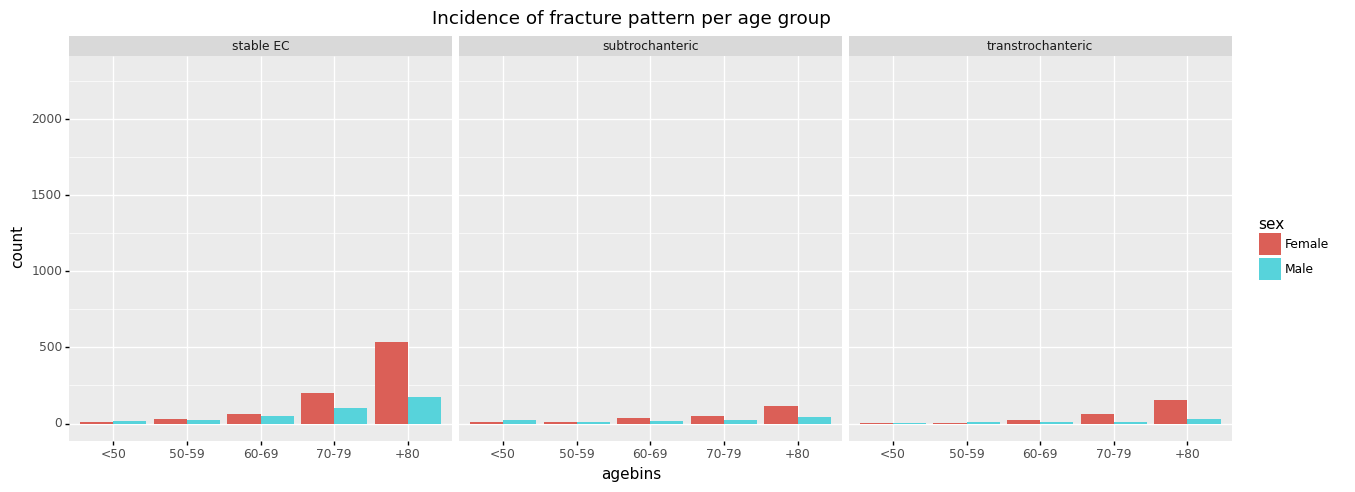

In [204]:
fig = (ggplot(dfc[~dfc['rows']], aes(x='agebins', fill='sex'))
       + geom_bar(position='dodge')
       + facet_grid('~ ao_class')
       + coord_cartesian(ylim = [0, 2300])
       + theme(figure_size=(15,5))
       + labs(title='Incidence of fracture pattern per age group')
      ).draw()
fig.show()

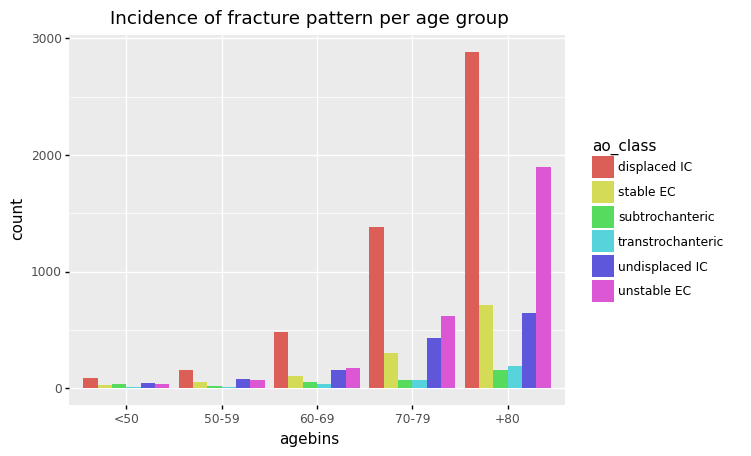

In [192]:
fig = (ggplot(dfc, aes(x='agebins', fill='ao_class'))
       + geom_bar(position='dodge')
       + labs(title='Incidence of fracture pattern per age group')
      ).draw()
fig.show()

In [193]:
yearbins = [-np.inf, 1995, 2000, 2005, 2010, 2015, np.inf]
dfc['yearbins'] = pd.cut(dfc['op_date'].dt.year, yearbins, 
                         labels=['1989-94','1995-99','2000-04','2005-09', '2010-14', '2015-20'])

In [220]:
dfc.groupby('yearbins').describe()

age                                                     
           count       mean        std   min   25%   50%   75%    max
yearbins                                                             
1989-94   1633.0  79.403552  10.851184  16.0  74.0  81.0  86.0  103.0
1995-99   1476.0  79.827913  11.246462  16.0  76.0  81.0  87.0  103.0
2000-04   1629.0  80.613260  11.064540  20.0  77.0  82.0  88.0  100.0
2005-09   1830.0  80.547541  11.444194  19.0  76.0  83.0  88.0  106.0
2010-14   2225.0  81.243146  10.802874  21.0  76.0  83.0  89.0  105.0
2015-20   2199.0  80.690314  11.551564  21.0  75.0  83.0  89.0  103.0

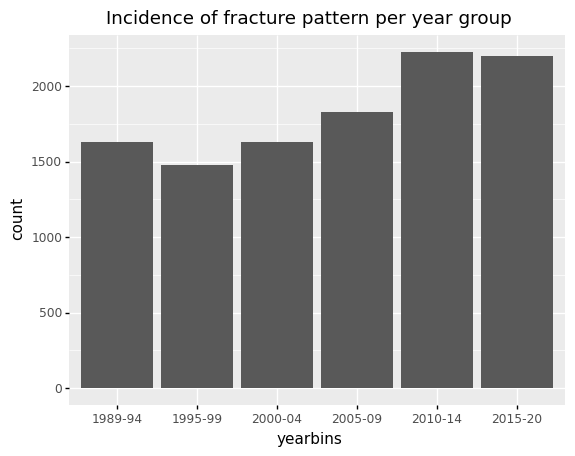

In [219]:
fig = (ggplot(dfc, aes(x='yearbins'))
       + geom_bar()
       + labs(title='Incidence of fracture pattern per year group')
      ).draw()
fig.show()

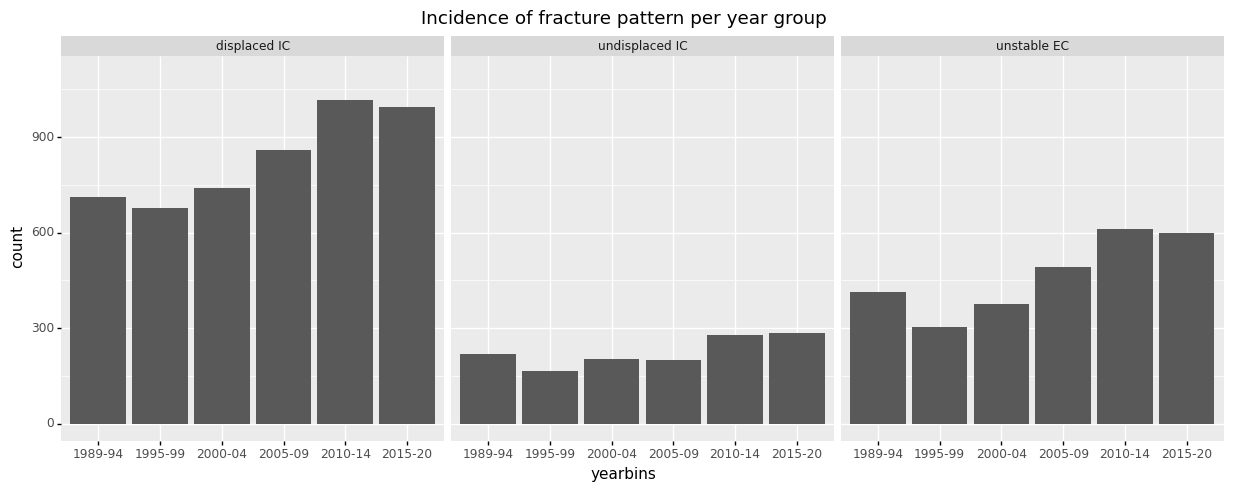

In [198]:
fig = (ggplot(dfc[dfc['rows']], aes(x='yearbins'))
       + geom_bar()
       + facet_grid('~ ao_class')
       + coord_cartesian(ylim = [0, 1100])
       + theme(figure_size=(15,5))
       + labs(title='Incidence of fracture pattern per year group')
      ).draw()
fig.show()

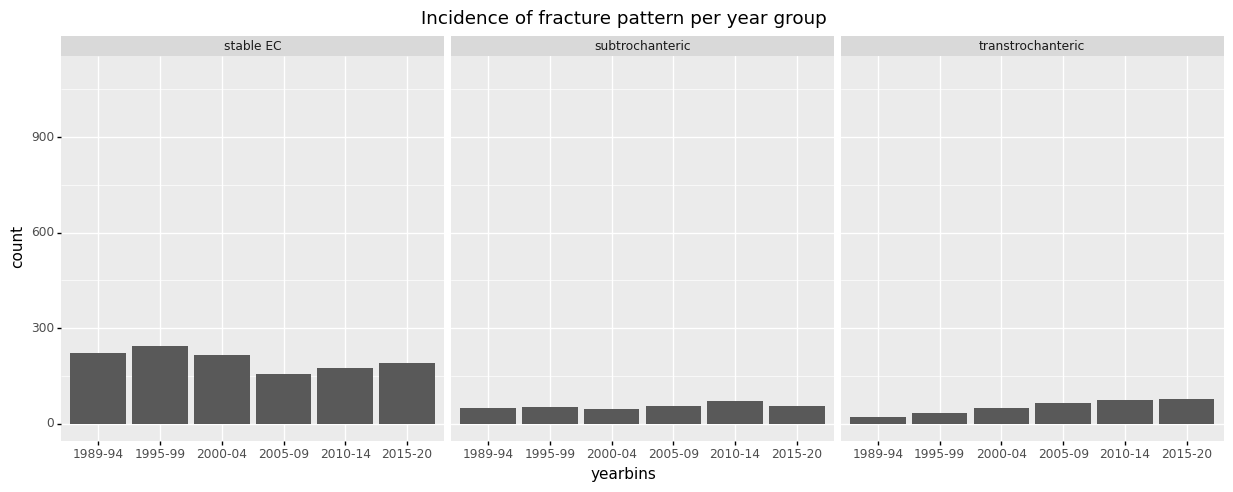

In [196]:
fig = (ggplot(dfc[~dfc['rows']], aes(x='yearbins'))
       + geom_bar()
       + facet_grid('~ ao_class')
       + coord_cartesian(ylim = [0, 1100])
       + theme(figure_size=(15,5))
       + labs(title='Incidence of fracture pattern per year group')
      ).draw()
fig.show()

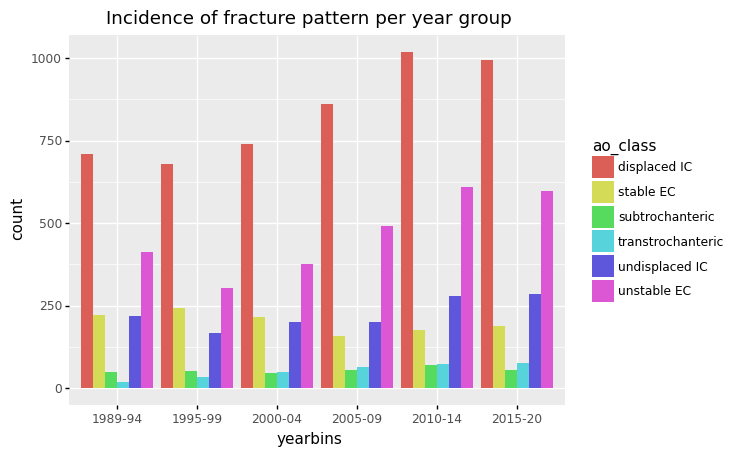

In [165]:
fig = (ggplot(dfc, aes(x='yearbins', fill='ao_class'))
       + geom_bar(position='dodge')
       + labs(title='Incidence of fracture pattern per year group')
      ).draw()
fig.show()